# Simple ARIMA model for non-seasonal time-serie forecast

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the time series of the challenge

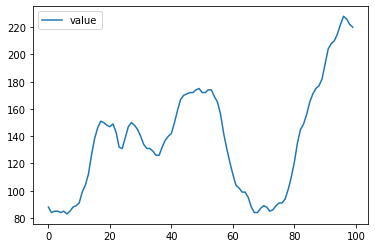

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('data/wwwusage.csv', names=['value'], header=0)
y = df.value
df.plot();

This abstract time serie does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regresive Moving Average (ARIMA) models


## 2. Build ARIMA model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time serie (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the Moving-Average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure stationarity

ARIMA models applies to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [3]:
from statsmodels.tsa.stattools import adfuller

print(adfuller(df)[1])  # p-value

0.12441935447109487


The p-value should be  less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat process on the differentiated serie if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationnary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

Text(0.5, 1.0, '2nd Order Differencing')

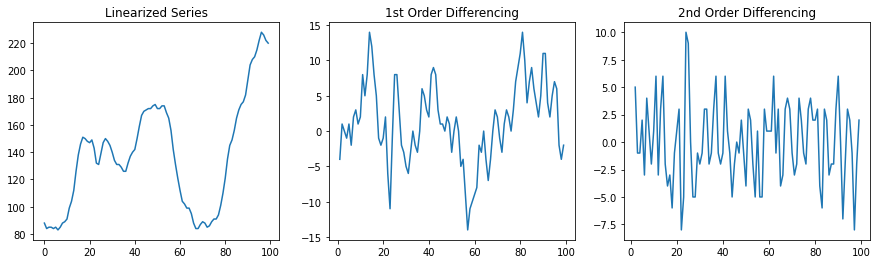

In [7]:
# Let's difference this and look at the ACFs
fig, axes = plt.subplots(1, 3,figsize=(15,4))

axes[0].plot(df); axes[0].set_title('Linearized Series')
# 1st Differencing
y_diff = df.diff().dropna()
axes[1].plot(y_diff); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
y_diff_diff = df.diff().diff().dropna()
axes[2].plot(y_diff_diff); axes[2].set_title('2nd Order Differencing')

In [9]:
# check with ADF Test for stationarity
print('p-value zero-diff: ', adfuller(df)[1])
print('p-value first-diff: ', adfuller(df.diff().dropna())[1])
print('p-value second-diff: ', adfuller(df.diff().diff().dropna())[1])

p-value zero-diff:  0.12441935447109487
p-value first-diff:  0.07026846015272707
p-value second-diff:  2.843428755547158e-17


We have a close-call here between one and two diff orders. Differentiating too much a time series may also reduce performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

In [5]:
y_diff = df.diff().dropna()
y_diff_diff = df.diff().diff().dropna()

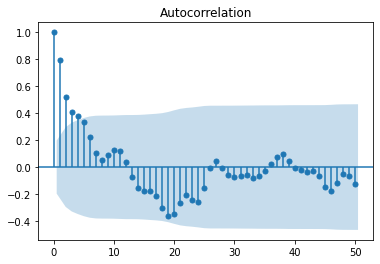

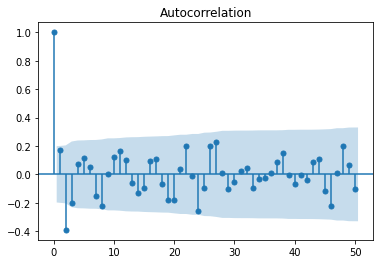

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y_diff, lags=50);
plot_acf(y_diff_diff, lags=50);

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (temptatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary (I refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

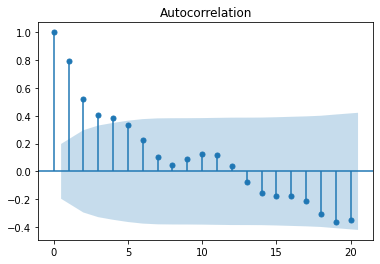

In [13]:
plot_acf(y_diff, lags=20);

We could choose q = 4, but it's more conservatively to try with `q=2` to start with.

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

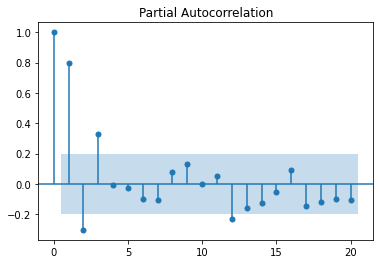

In [12]:
plot_pacf(y_diff, lags=20);

We could choose `p = 3` as the first 3 lag terms seems above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d` and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the the model
- print the model (`.summary`)

In [21]:
y_diff

,value
1,-4.0
2,1.0
3,0.0
4,-1.0
5,1.0
...,...
95,7.0
96,6.0
97,-2.0
98,-4.0


In [61]:
from statsmodels.tsa.arima_model import ARIMA

#ARIMA(p, d, q)
model = ARIMA(y,(1,1,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Thu, 19 Aug 2021   AIC                            515.579
Time:                        14:50:09   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.384      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089      5.932      0.000       0.355       0.705
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5764           +0.0000j            1.5764            0.0000
MA.1           -1.8879           +0.0000j            1.8879            0.5000
-----------------------------------------------------------------------------
"""

☝️ If your p-values are too high, try remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate overall performance of your fit by minimizing the [`AIC - akaike information criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remains low) and maintain a quasi similar AIC score than other models

## 3. Evaluate model performance

👉 Visualize your model predictions with `.plot_predict()`

- Look closely at the method default params, especially `dynamic`. 
- Do you think your model would have such good performance in reality?

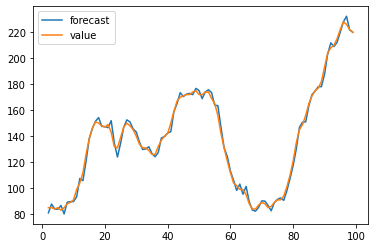

In [62]:
model.plot_predict(dynamic=False);

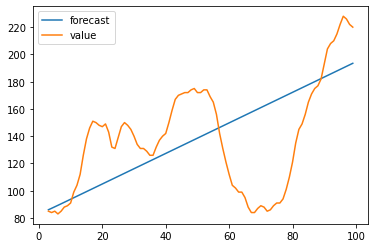

In [29]:
model.plot_predict(dynamic=True);

`dynamicbool`, optional

The dynamic keyword affects in-sample prediction. If dynamic is False, then the in-sample lagged values are used for prediction. If dynamic is True, then in-sample forecasts are used in place of lagged dependent variables. The first forecast value is start.

☝️ `dynamic=False` actually makes use of all available values `y` in order to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ it's previouly predicted value for 86
- etc...iteratively until 100

In [ ]:
arima.plot_predict(end=250);
fig = plt.gcf(); fig.set_size_inches(12, 5);

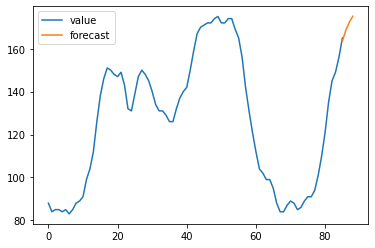

In [67]:
dta = y[0:85]

model_bis = ARIMA(y,(1,1,1)).fit()

#model_bis.plot_predict( dynamic=True);

fig, ax = plt.subplots()
ax = y.loc[0:85].plot(ax=ax)
fig = model_bis.plot_predict(85,88, dynamic=True, ax=ax,
                       plot_insample=False)

plt.show();

☝️ That's still not a _true_ forecast!! Why??

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` serie during the fitting phase!
</details>

### 3.1 Out-of-sample forecasts (real "future")

👉 Create a train-test-split keep the last 15 datapoints only for the test set, and train your ARIMA on the train set only.

In [68]:
# Create a correct Training/Test split to predict the last 50 points
train = y[:85]
test = y[85:]



👉 We are "now" in step 85 and have never seen the future:
- Use `.forecast()` method on your fitted model to "forecast" the 15 next datapoints (i.e beyond the end of your train dataset) 
- Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

In [69]:
# Build Model
arima = ARIMA(train, order=(1, 1, 1))  
arima = arima.fit()

In [70]:
# Forecast
forecast, std_err, confidence_int = arima.forecast(len(test), alpha=0.05)  # 95% confidence

In [73]:
import numpy as np

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

👉 Try to also plot your previous 85 `y` real datapoints to better grasp model performance relative to the past

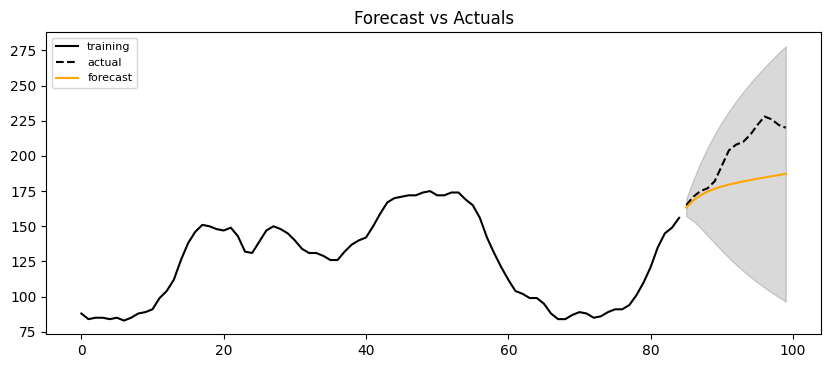

In [75]:
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals if you really want)

Note: residuals are constructed by 'seing' all data as in `plot_predict(dynamic=False)`

Also try to plot a histogram or kde fit of the residuals to see if they are approximately normally distributed.

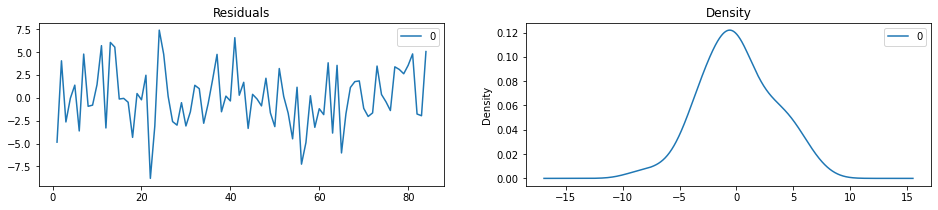

In [76]:
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [77]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

👉 Play with you ARIMA hyper-parameters and see the impact on your forecast performance

In [86]:
# Build Model
arima = ARIMA(train, order=(1, 1, 1))  
arima = arima.fit()

# Forecast
forecast, std_err, confidence_int = arima.forecast(len(test), alpha=0.05)  # 95% confidence

forecast = pd.Series(forecast)
forecast.index = test.index
forecast_accuracy(pd.Series(forecast), pd.Series(test))

{'mape': 0.1030090092757897,
 'me': -22.120318691133047,
 'mae': 22.120318691133047,
 'mpe': -0.1030090092757897,
 'rmse': 26.755423765779096,
 'acf1': 0.8749545359946349,
 'corr': 0.9497234493252464,
 'minmax': 0.10300900927578982}

In [102]:
# Build Model
arima = ARIMA(train, order=(2, 0, 3))  
arima = arima.fit()

# Forecast
forecast, std_err, confidence_int = arima.forecast(len(test), alpha=0.05)  # 95% confidence

forecast = pd.Series(forecast)
forecast.index = test.index
forecast_accuracy(pd.Series(forecast), pd.Series(test))

At iterate   15    f=  2.61057D+00    |proj g|=  4.28662D-03

At iterate   20    f=  2.61057D+00    |proj g|=  6.92779D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     31      1     0     0   2.620D-06   2.611D+00
  F =   2.6105656793942091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59866D+00    |proj g|=  3.77431D-03

At iterate    5    f=  2.59858D+00    |proj g|=  5.67901D-04

At itera

/home/nandosoq/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/home/nandosoq/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


{'mape': 0.11242374690832806,
 'me': -24.111946031844,
 'mae': 24.529366358830917,
 'mpe': -0.11004961132881125,
 'rmse': 32.38163326716252,
 'acf1': 0.8575405865800529,
 'corr': 0.1123862947832965,
 'minmax': 0.11241320460956294}

## 4 Grid Search

Try to run your own gridsearch for (p,d,q) using `pmdarima`. Use at least
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [101]:
import pmdarima as pm
smodel = pm.auto_arima(train,
                       start_p=1, max_p=4,
                       start_q=1, max_q=4,
                       start_d=1, max_d=3,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True                    
                      )

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=481.727, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=826.197, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=547.248, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1069.925, Time=0.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=449.642, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=456.236, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=451.184, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=449.178, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=457.851, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=453.456, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=446.858, Time=0.24 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=458.408, Time=0.15 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.

## (Optional) Cross-validate performance of your model?

In practice, Results and GridSearch should always be cross validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create continguous K-folds so as to truely evaluate the performance of your model and find the best hyper-params after cross validation

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>